In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize as spopt
import pandas as pd

In [11]:
def datacleaner():
    '''
    Function that loads the data and does the basic filtering required
    for the purposes of this project
    Output: cleaned and filtered data
    '''
    
    
    data = pd.read_csv('sdss_quasars.dat', delim_whitespace=True, engine='python', index_col=False)
    data_clean = data[(data['LOGL3000_ERR']<0.1) & 
                (data['LOGL_MGII_ERR']<0.1) & 
                (data['R_6CM_2500A']>0) & 
                (data['LOGBH_ERR']<0.2) &
                (data['LOGL3000']>0) &
                (data['LOGL_MGII']>0) &
                (data['LOGBH']>0)]
    
    
    median = np.median((data_clean['R_6CM_2500A'])) #calculating the median in radio loudness

    #now using the meadian to split the data into 2 subsamples
    above_median = data_clean[(data_clean['R_6CM_2500A'])>median] 
    below_median = data_clean[(data_clean['R_6CM_2500A'])<=median]
    
    #further filtering while keeping the same 2 subsamples as before
    above_median_clean = above_median[(above_median['LOGL1350_ERR']<0.1) & (above_median['LOGL1350']>0)]  
    below_median_clean = below_median[(below_median['LOGL1350_ERR']<0.1) & (below_median['LOGL1350']>0)] 
    
    return data_clean, above_median, below_median, above_median_clean, below_median_clean


def corner_scatter_plot(h_array, labels):
    '''
    Corner plot for visualizing columns of data against each other 
    and checking for possible correlations by performing pearson r tests
    Inputs: array of values h_array
    '''
    
    ndims = len(h_array)
    fig, axes = plt.subplots(ndims,ndims,figsize=(10,10))
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    for i in range(ndims): 
        for j in range(ndims): 
            if i == j:
                axes[i,j].hist(h_array[i], bins=20)
            elif i > j:
                (rcor, rpval) = sps.pearsonr(h_array[j],h_array[i])
                (rhocor, rhopval) = sps.spearmanr(h_array[j],h_array[i])
                axes[i,j].scatter(h_array[j], h_array[i], s=1)
                axes[i,j].set_title(f'r = {np.round(rcor, 2)}')
            else:
                axes[i,j].axis('off')
            if j == 0:
                if i == j:
                    axes[i,j].set_ylabel('counts',fontsize=12)
                else:
                    axes[i,j].set_ylabel(labels[i],fontsize=12)
            if i == 3:
                axes[i,j].set_xlabel(labels[j],fontsize=12)
    plt.show()
    
    return


def linear_fit(x, y):
    '''
    Simple function that performs linear regreassion using curve_fit
    and also checks for linear correlation using pearson's r test
    Inputs: arrays of x and y values
    Output: list of gradianet and ffset of the fit r2,
            pearson's r value rcor
    '''  
    
    func = lambda x, a, b: x*a+b 
    r2, pcov = spopt.curve_fit(func, x, y, p0=(1,1))    #defining the fit
    rcor, rpval = sps.pearsonr(x,y)
    
    return r2, rcor


def plotting_linear_fit(h_array, labels):
    '''
    linear regression visualization for 2 different fits
    Inputs: h_array contains x and y coordinates for each of the 2
    '''
    
    r2, rcor = linear_fit(h_array[0], h_array[1])
    r2_2, rcor_2 = linear_fit(h_array[2], h_array[3])
    
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,5))
    ax1.plot(h_array[0], h_array[1], "o");
    ax1.plot(h_array[0], r2[0]*h_array[0] + r2[1], lw=2, label = 'a = %a ' %round(r2[0],3)  + 
             '\n' + 'b = %r' %round(r2[1],3) )
    ax1.set_title('r = %r ' %round(rcor,3))
    ax1.legend()
    ax2.plot(h_array[2], h_array[3], 'o')
    ax2.plot(h_array[2], r2_2[0]*h_array[2] + r2_2[1], lw=2, 
             label = 'a = %a ' %round(r2_2[0],3)  + '\n' + 'b = %r' %round(r2_2[1],3))
    ax2.set_title('r = %r ' %round(rcor_2,3))
    ax2.legend()
    ax1.set_xlabel(labels[0], fontsize=10)
    ax1.set_ylabel(labels[1], fontsize=10)
    ax2.set_xlabel(labels[2], fontsize=10)
    ax2.set_ylabel(labels[3], fontsize=10)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.show()
    
    return 


def bootsrtrapping(nsims, n, data):
    '''
    Function for sampling n data, nsims times, for determining its distribution
    and (possibly) confidence intervals
    Inputs: number of simulations nsims,
            number of data sampled n,
            dataframe data
    Output: distribution of gradient a_arr and offset b_arr
    '''
    
    a_arr = np.zeros(nsims)
    b_arr = np.zeros(nsims)
    for i in range(nsims):
        sample=data.sample(n, replace=True)  #taking a sample of size n in each trial 

        r2, pcov = linear_fit(sample.LOGL3000, sample.LOGL_MGII) 
        #we're interested in correlation
        #between these two columns
        #so we sample grad a and offset b of the fit
        a_arr[i] = r2[0]
        b_arr[i] = r2[1]
        
    return a_arr, b_arr


def histrebin(mininbin, array): 
    '''
    Rebins a histogram so there are at least mininbin counts per bin
    Inputs: array of values,
    Output: rebined counts and bin edges
    '''
    
    counts, edges = np.histogram(array, bins=10, density=False)
    edges_new=np.zeros(1)
    counts_new=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges_new[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  
            # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: 
                # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts_new[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts_new=np.append(counts_new,countsum)
            edges_new=np.append(edges_new,edges[i])
            countsum=0        

    return counts_new, edges_new


def plotting_grad_offset(h_array, labels):
    '''
    Visuliation of grad a and offset b of the linear fit
    along with a scatter plot for correlation checking between them
    Inputs: array of gradient a and offset b values
    '''
    
    fig, axs = plt.subplots(2,2, figsize=(9,7))
    fig.subplots_adjust(wspace=0.4)
    axs[0,0].hist(h_array[0], bins=20,histtype='step', label=labels[0])
    axs[0,0].hist(h_array[1], bins=20,histtype='step', label=labels[1])
    axs[0,1].hist(h_array[2], bins=20,histtype='step', label=labels[2])
    axs[0,1].hist(h_array[3], bins=20,histtype='step', label=labels[3])
    axs[1,0].plot(h_array[0], h_array[2], "o")
    axs[1,1].plot(h_array[1], h_array[3], "o")

    axs[0,0].set_xlabel("a_arr", fontsize=12)
    axs[0,0].set_ylabel("counts", fontsize=12)
    axs[0,1].set_xlabel("b_arr", fontsize=12)
    axs[0,1].set_ylabel("counts", fontsize=12)
    axs[1,0].set_xlabel(labels[0], fontsize=12)
    axs[1,0].set_ylabel(labels[2], fontsize=12)
    axs[1,1].set_xlabel(labels[1], fontsize=12)
    axs[1,1].set_ylabel(labels[3], fontsize=12)
    axs[0,0].legend()
    axs[0,1].legend(loc=2)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.show() 
    return

# Data description

The data set sdss_quasars.dat contains measurements by the Sloan Digital Sky Survey 
(SDSS - http://www.sdss.org/) of various parameters obtained for a sample of 10000 "quasars" - supermassive black 
holes where gas drifts towards the black hole in an accretion disk, which heats up via gravitational potential 
energy release, to emit light at optical and UV wavelengths. This project is about extracting and plotting this 
multivariate data and searching for possible correlations between the different parameters: we are not 
interested in the physical interpretation here, just the statistical properties of the data and whether or not 
significant correlations are present.
<br><br>
The first three columns of the data file give the object ID and position (RA and Dec in degrees), then the redshift of the object, a target flag which you can ignore, followed by the total "bolometric" log10(luminosity), also called ‘log-luminosity’. The luminosity units are erg/s - note that 1 erg/s=10-7 W, though this is not important here. The error bar on log-luminosity is also given. Then follows a variable giving the ratio of radio to UV (250 nm) emission (so-called 
"radio loudness"), three pairs of columns listing a broadband "continuum" log-luminosity (and error) at three 
different wavelengths, and seven pairs of columns each listing a specific emission line log-luminosity (and 
error). Finally, a pair of columns gives an estimate of the black hole mass and its error (in log10 of the mass in 
solar-mass units)

# Initial inspection / correlation checking

We start by doing a visualization of our data using a corner plot. 
<br>
We also check for possible (linear correlations) using Spearman's r statistic, shown as the individual plot title.
<br>
We find strong evidence of linear correlation between LOG_LMGII and LOG_L3000.

<IPython.core.display.Javascript object>


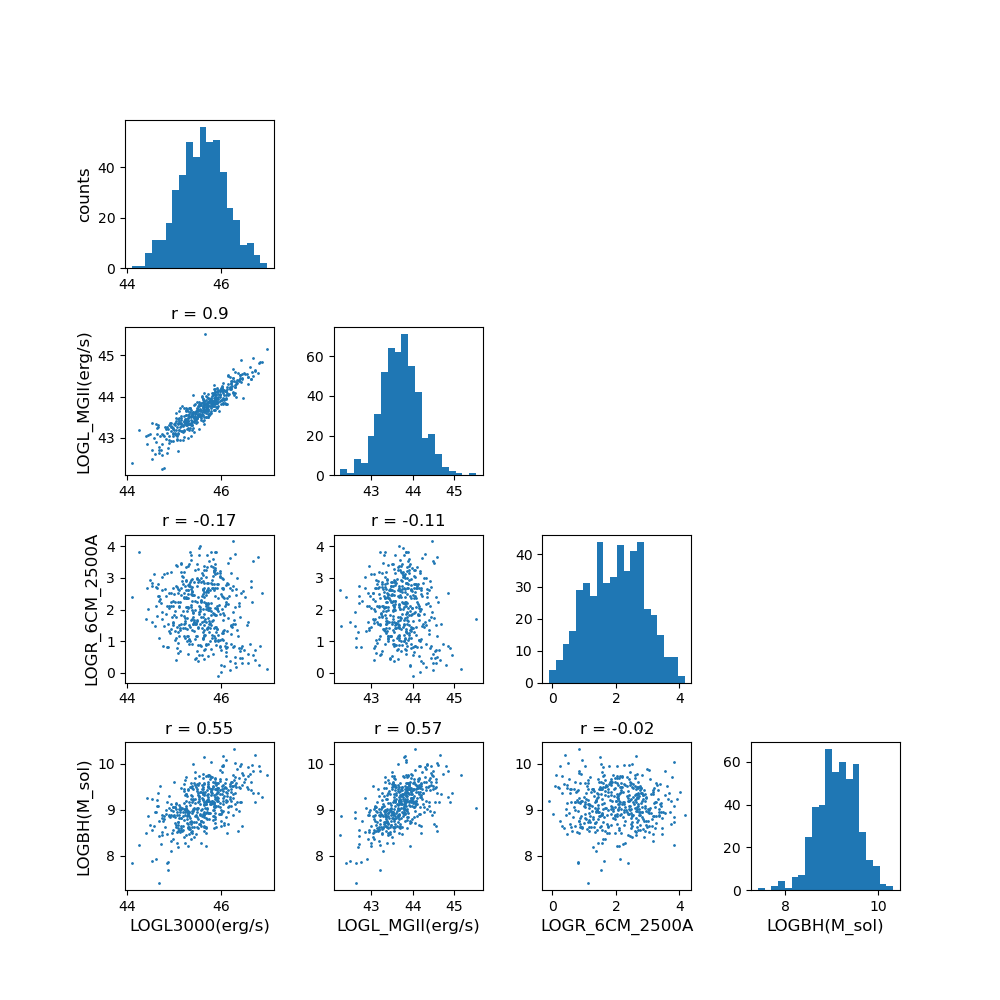

In [3]:
sdss_clean, above_median, below_median, above_median_clean, below_median_clean = datacleaner()

h_array=[sdss_clean['LOGL3000'],sdss_clean['LOGL_MGII'],np.log10(sdss_clean['R_6CM_2500A']),sdss_clean['LOGBH']]
labels = ['LOGL3000(erg/s)','LOGL_MGII(erg/s)','LOGR_6CM_2500A','LOGBH(M_sol)']

corner_scatter_plot(h_array, labels)

# Linear Regression

The next step is to apply a linear fit in order to aqcuire the gradient a and offset b of the fit.
<br>
We do that for both the LOG10 case and the linear case.
<br>
It appears that the linear case does not follow a linear correlation.

C:\Users\George Zervas\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<IPython.core.display.Javascript object>


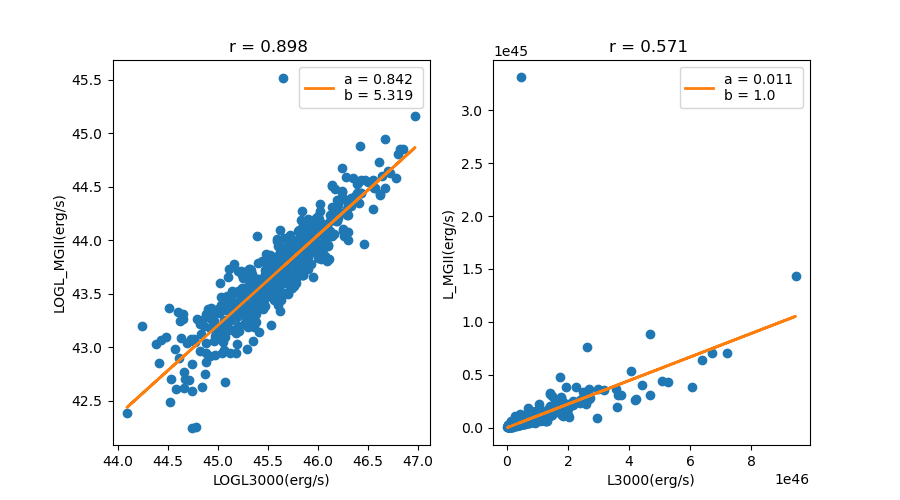

In [4]:
h_array=[sdss_clean['LOGL3000'],sdss_clean['LOGL_MGII'], 10**sdss_clean['LOGL3000'], 10**sdss_clean['LOGL_MGII']]
labels = ['LOGL3000(erg/s)','LOGL_MGII(erg/s)','L3000(erg/s)','L_MGII(erg/s)']

plotting_linear_fit(h_array, labels)

# Bootstrapping

We procceed to do some bootstrapping to get the distributions of both the gradient a and the offset b of the fit. <br>
Also, a quick inspection of the covariance matrix of a and b reveal correlation between them as the non-diagonal terms are >0.
<br>
This is also confirmed by the scatter plot of gradient vs offset shown below, where a correlation is again evident.

<IPython.core.display.Javascript object>


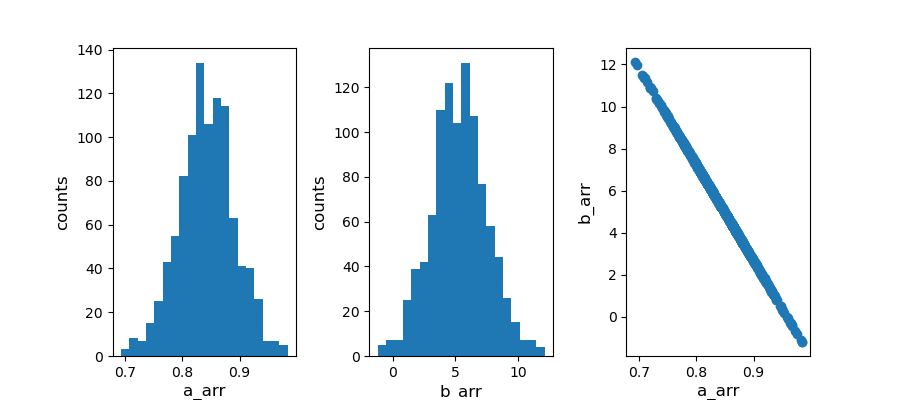

The covariance matrix of a(gradient) and b(offset) is: 
 [[ 2.35620368e-03 -1.07676244e-01]
 [-1.07676244e-01  4.92110868e+00]]


In [5]:
ntrials = 1000
npoints = 100

a_arr, b_arr = bootsrtrapping(ntrials, npoints, sdss_clean)

#plotting the histograms of a_arr(gradient) and b_arr(offset) for our samples
#as well as a_arr vs b_arr where a linear correlation is evident
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,4))
fig.subplots_adjust(wspace=0.4)
ax1.hist(a_arr, bins=20)
ax2.hist(b_arr, bins=20)
ax3.plot(a_arr, b_arr, "o")

ax1.set_xlabel("a_arr", fontsize=12)
ax1.set_ylabel("counts", fontsize=12)
ax2.set_xlabel("b_arr", fontsize=12)
ax2.set_ylabel("counts", fontsize=12)
ax3.set_xlabel("a_arr", fontsize=12)
ax3.set_ylabel("b_arr", fontsize=12)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.show()


print('The covariance matrix of a(gradient) and b(offset) is: ' + '\n',  np.cov(a_arr, b_arr))

# Sample Split 

We now split the data into two samples, using the median of the radio loudness column 'R_6CM_2500A'. In that sense the radio loud galaxies lie above the median and the radio quiet below. 

## Statistical Tests
the next step is to check whether the black hole masses corresponding to each sample, could originate from the same population. To do that, we perform a student's t-test using the columns corresponding to black hole mass ('LOGBH') above and below the median as benchmarks.
<br>
The results (p = 0.811) reveal that there is strong evidence supporting that the two samples of black hole masses in fact originate from the same population.

<IPython.core.display.Javascript object>


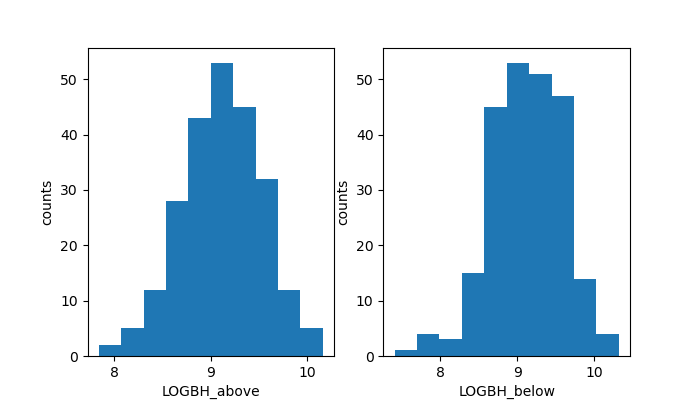

t-test Mass above meadian vs. Mass below median
T =  -0.239 and p-value = 0.811


In [6]:
#making a plot to quickly chen whether our data are normaly distributed for the test
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,4))
ax1.hist(above_median['LOGBH'])
ax2.hist(below_median['LOGBH'])
ax1.set_xlabel('LOGBH_above')
ax1.set_ylabel('counts')
ax2.set_xlabel('LOGBH_below')
ax2.set_ylabel('counts')
plt.show()

#using a 2-sample t-test to determine whether the black hole mass data
#in each subsample can be drawn from a distribution with the same mean
tstat, pval = sps.ttest_ind(above_median['LOGBH'],below_median['LOGBH'],equal_var=True)
print("t-test Mass above meadian vs. Mass below median")
print("T = ", np.round(tstat, 3),"and p-value =", np.round(pval, 3))

## Linear Regression 
We now that the data in columns 'LOGL_MGII' and 'LOGL3000' are linearly correlated as we already demonstrated. The next step is to check whether this correlation persists in both the radio loud and radio quiet galaxies.
<br>

<IPython.core.display.Javascript object>


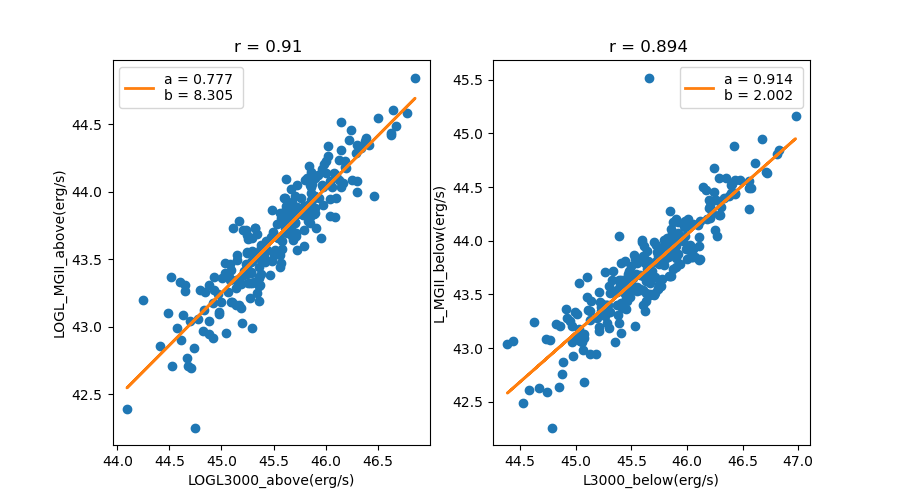

In [7]:
h_array=[above_median['LOGL3000'],above_median['LOGL_MGII'],below_median['LOGL3000'], below_median['LOGL_MGII']]
labels = ['LOGL3000_above(erg/s)','LOGL_MGII_above(erg/s)','L3000_below(erg/s)','L_MGII_below(erg/s)']

plotting_linear_fit(h_array, labels)

# Bootstrapping

We repeat the same bootstrapping analysis to get the distributions of both the gradient a and the offset b of the fit above and below the radio loudness median. <br>
Then, we plot a histogram for a and b showing if their distributions are different above and below the median.
<br>
We immediately see that while both seem to be gaussian in shape, the means of the distributions appear to change from below the meadian to above.
<br>
We will perform a student's t-test to quickly check if there is a chance that these 2 distributions could originate from a parent distribution with the same mean.
<br>
The results of the t-test reveal that the 2 distribution are with greater thatn 99% certainty, not from the same population. This further implies that that radio loud (above median) galaxies haave a different luminosity relation than radio quiet (below median) ones.


In [8]:
ntrials = 1000
npoints = 50

a_arr_above, b_arr_above = bootsrtrapping(ntrials, npoints, above_median)
a_arr_below, b_arr_below = bootsrtrapping(ntrials, npoints, below_median)

<IPython.core.display.Javascript object>


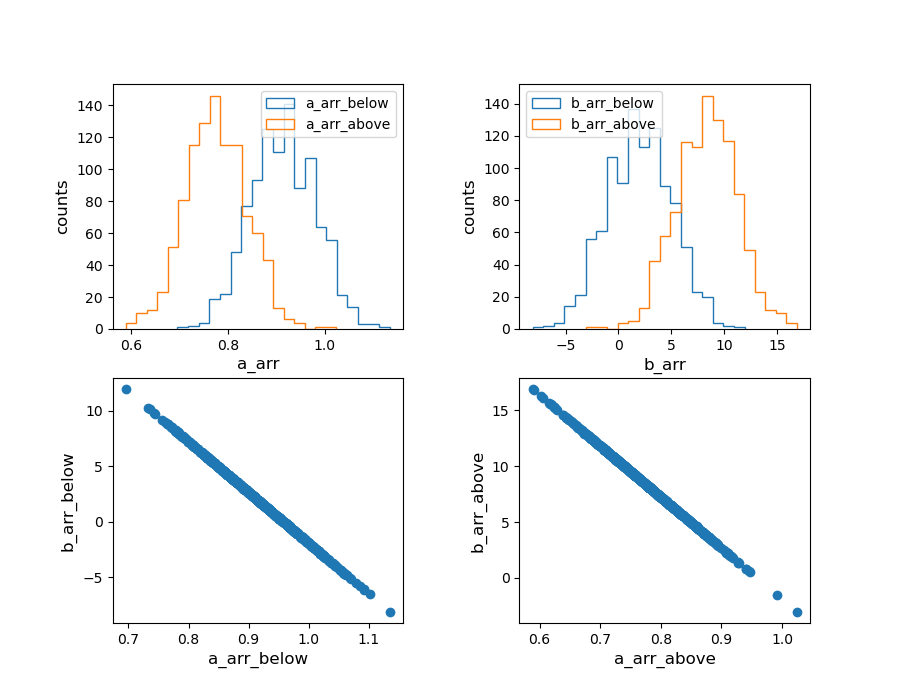

t-test offset above meadian vs. offset below median
T =  47.763 and p-value = 0.0


In [9]:
h_array = [a_arr_below, a_arr_above, b_arr_below, b_arr_above]
labels = ['a_arr_below', 'a_arr_above', 'b_arr_below', 'b_arr_above']

plotting_grad_offset(h_array, labels)

tstat, pval = sps.ttest_ind(a_arr_below,a_arr_above,equal_var=True)
print("t-test offset above meadian vs. offset below median")
print("T = ", np.round(tstat, 3),"and p-value =", np.round(pval, 3))

As a last step, we apply some extra filters to the two sample datasets and we define a new 'colour' based on the differences of existing colours, to see if anything interesting stands out there.
<br>
We plot the distribution of the values of the newly defined colour above and below the median as before, having first rebinned the histogram to have at least 20 counts per bin for better statistics.
<br>
Once more we perform a student's t-test to check whether the colour distributions above and below the radio loudness median could originate from a parent distribution of the same mean.
<br>
Our results of pval = 0.545, indicate that we cannot refute the null hypothesis with any significant certainty and as a result, the new colour appears to have the same distribution for galaxies above and below the radio loudness meadian.

<IPython.core.display.Javascript object>


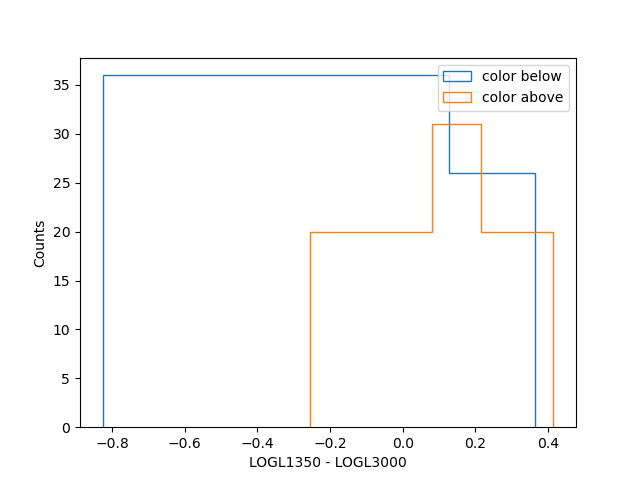

t-test color_above vs. color_below
T =  0.649 and p-value = 0.545


In [10]:
#defining a dataset for the color '1350-3000' for each subsample 
color_above=above_median_clean['LOGL1350'] - above_median_clean['LOGL3000'] 
color_below=below_median_clean['LOGL1350'] - below_median_clean['LOGL3000']

mincounts = 20
counts_above, edges_above = histrebin(mincounts, color_above)
counts_below, edges_below = histrebin(mincounts, color_below)

plt.figure()
plt.hist(edges_below[:-1], edges_below, weights=counts_below, histtype='step', label='color below')
plt.hist(edges_above[:-1], edges_above, weights=counts_above, histtype='step', label='color above')
plt.xlabel('LOGL1350 - LOGL3000')
plt.ylabel('Counts')
plt.legend()
plt.show()

tstat, pval = sps.ttest_ind(edges_above,edges_below,equal_var=True) #finally doing a 2-sample t-test again 
print("t-test color_above vs. color_below")
print("T = ", np.round(tstat, 3),"and p-value =", np.round(pval, 3))
